In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from mixedbridge.solvers.sde import Euler
from mixedbridge.stochastic_processes.wiener import WienerProcess
from mixedbridge.stochastic_processes.examples import CellDiffusionProcess, CellDiffusionAuxProcess
from mixedbridge.stochastic_processes.gbp import GuidedBridgeProcess
from mixedbridge.baselines.pcn import PreconditionedCrankNicolson
from mixedbridge.baselines.sm import ScoreMatchingReverseBridge
from mixedbridge.networks.score_net import ScoreNetSmall

In [3]:
dim = 2
alpha = 1. / 16.
sigma = 0.1
T = 4.0
dt = 1. / 500
dtype = jnp.float32
rng_key = jax.random.PRNGKey(42)
x0 = jnp.array([0.1, -0.1], dtype=dtype)
xT = jnp.array([2.0, -0.1], dtype=dtype)

n_batches = 32

In [4]:
wiener_process = WienerProcess(dim=dim, dtype=dtype, T=T, dt=dt)
cell_proc = CellDiffusionProcess(T=T, dt=dt, dim=dim, dtype=dtype, alpha=alpha, sigma=sigma)
cell_aux_proc = CellDiffusionAuxProcess(T=T, dt=dt, dim=dim, dtype=dtype, alpha=alpha, sigma=sigma)

Text(0.5, 1.0, 'Unconditional process')

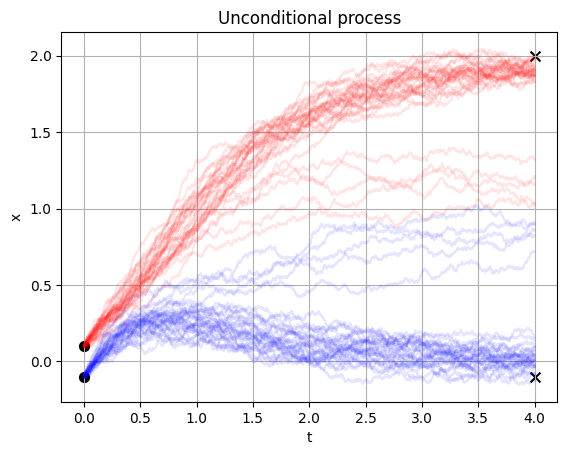

In [5]:
cell_proc_solver = Euler(cell_proc, wiener_process)
cell_path = cell_proc_solver.solve(x0, dWs=None, rng_key=rng_key, log_likelihood=False, n_batches=n_batches)
for i in range(n_batches):
    plt.plot(cell_path.ts, cell_path.xs[i, :, 0], color='r', alpha=0.1)
    plt.plot(cell_path.ts, cell_path.xs[i, :, 1], color='b', alpha=0.1)
plt.scatter(0.0, x0[0], color='black', marker='o', s=50)
plt.scatter(0.0, x0[1], color='black', marker='o', s=50)
plt.scatter(T, xT[0], color='black', marker='x', s=50)
plt.scatter(T, xT[1], color='black', marker='x', s=50)
plt.xlabel('t')
plt.ylabel('x')
plt.grid()
plt.title("Unconditional process")

In [6]:
L0 = jnp.eye(dim, dtype=dtype)
Sigma0 = jnp.eye(dim, dtype=dtype) * 1e-10
cell_guided_proc = GuidedBridgeProcess(cell_proc, cell_aux_proc, L0, Sigma0, x0=x0, xT=xT)
cell_guided_proc_solver = Euler(cell_guided_proc, wiener_process)
cell_guided_path = cell_guided_proc_solver.solve(x0, dWs=None, rng_key=rng_key, log_likelihood=True, n_batches=n_batches)

Text(0.5, 1.0, 'Guided process')

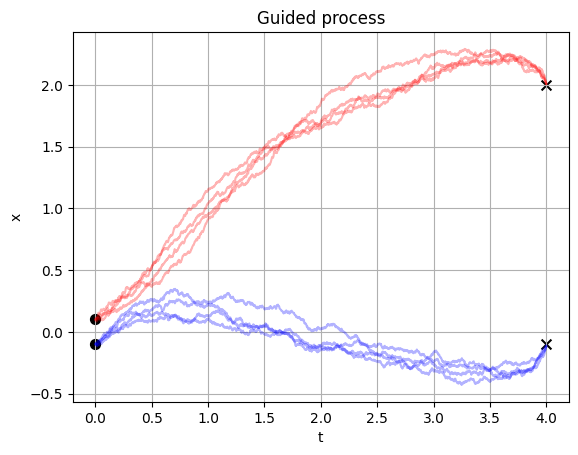

In [7]:
plt.figure()
for i in range(4):
    plt.plot(cell_guided_path.ts, cell_guided_path.xs[i, :, 0], color='r', alpha=0.3)
    plt.plot(cell_guided_path.ts, cell_guided_path.xs[i, :, 1], color='b', alpha=0.3)
plt.scatter(0.0, x0[0], color='black', marker='o', s=50)
plt.scatter(0.0, x0[1], color='black', marker='o', s=50)
plt.scatter(T, xT[0], color='black', marker='x', s=50)
plt.scatter(T, xT[1], color='black', marker='x', s=50)
plt.xlabel('t')
plt.ylabel('x')
plt.grid()
plt.title("Guided process")

In [8]:
mcmc_model = PreconditionedCrankNicolson(
    x0=x0,
    xT=xT,
    ori_proc=cell_proc,
    aux_proc=cell_aux_proc,
    rho=0.98,
    L0=L0,
    Sigma0=Sigma0,
    rng_key=jax.random.PRNGKey(42),
    n_batches=n_batches
)
path_mcmc, lls = mcmc_model.run(n_iters=2000, verbose=True, log_every=100)

Iteration 1/2000: log likelihood = 152.61138916015625
Iteration 101/2000: log likelihood = 190.91748046875
Iteration 201/2000: log likelihood = 213.66766357421875
Iteration 301/2000: log likelihood = 223.55612182617188
Iteration 401/2000: log likelihood = 228.01528930664062
Iteration 501/2000: log likelihood = 244.69105529785156
Iteration 601/2000: log likelihood = 251.77383422851562
Iteration 701/2000: log likelihood = 245.81195068359375
Iteration 801/2000: log likelihood = 269.5398254394531
Iteration 901/2000: log likelihood = 273.7406005859375
Iteration 1001/2000: log likelihood = 281.2436828613281
Iteration 1101/2000: log likelihood = 268.7689514160156
Iteration 1201/2000: log likelihood = 268.9494934082031
Iteration 1301/2000: log likelihood = 275.1187438964844
Iteration 1401/2000: log likelihood = 274.8069152832031
Iteration 1501/2000: log likelihood = 273.8812255859375
Iteration 1601/2000: log likelihood = 271.0010681152344
Iteration 1701/2000: log likelihood = 262.1141357421875

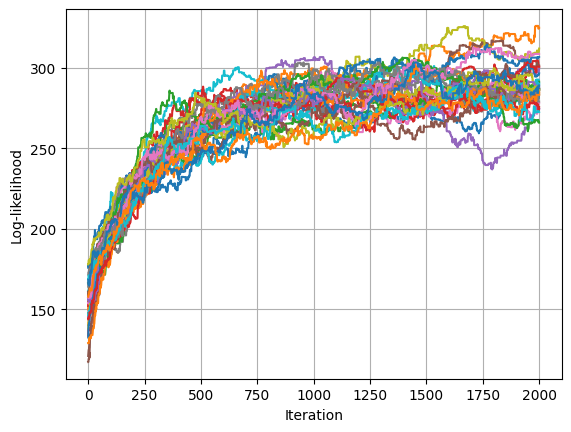

In [9]:
for i in range(n_batches):
    plt.plot(lls[:, i])
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.grid()
# plt.savefig('./cell_mcmc_lls.png', dpi=150, bbox_inches='tight')

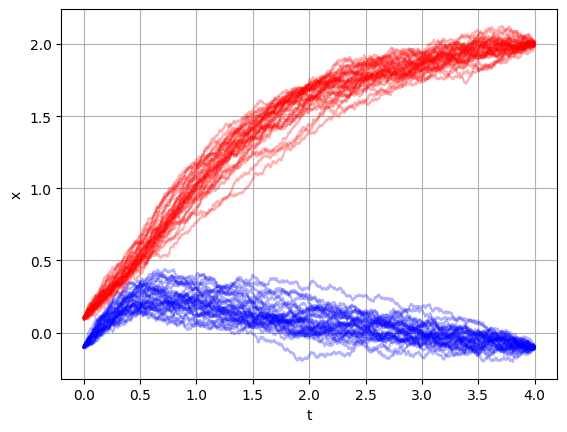

In [10]:
for i in range(n_batches):
    # plt.plot(path.ts, path.xs[i, :, 0], color='r', alpha=0.1)
    # plt.plot(path.ts, path.xs[i, :, 1], color='b', alpha=0.1)
    plt.plot(path_mcmc.ts, path_mcmc.xs[i, :, 0], color='r', alpha=0.3)
    plt.plot(path_mcmc.ts, path_mcmc.xs[i, :, 1], color='b', alpha=0.3)
plt.xlabel('t')
plt.ylabel('x')
plt.grid()
# plt.savefig('./cell_mcmc_sample.png', dpi=150, bbox_inches='tight')

In [31]:
sm_model = ScoreMatchingReverseBridge(
    x0=x0,
    xT=xT,
    process=sde,
    model=ScoreNetSmall(out_dim=dim, hidden_dims=[20, 20, 20, 20]),
    rng_key=jax.random.PRNGKey(42),
    n_batches=64,
    lr=1e-3
)

In [40]:
sm_path, reverse_bridge = sm_model.run(n_iters=5000)

Iter 1/5000, Loss: 40376.8671875
Iter 101/5000, Loss: 39737.0
Iter 201/5000, Loss: 39833.14453125
Iter 301/5000, Loss: 39905.421875
Iter 401/5000, Loss: 39371.609375
Iter 501/5000, Loss: 39591.98046875
Iter 601/5000, Loss: 39387.921875
Iter 701/5000, Loss: 39859.91796875
Iter 801/5000, Loss: 39482.890625
Iter 901/5000, Loss: 39125.37109375
Iter 1001/5000, Loss: 39300.265625
Iter 1101/5000, Loss: 39483.01953125
Iter 1201/5000, Loss: 39893.9453125
Iter 1301/5000, Loss: 39220.1796875
Iter 1401/5000, Loss: 39026.82421875
Iter 1501/5000, Loss: 39444.5625
Iter 1601/5000, Loss: 39484.7421875
Iter 1701/5000, Loss: 39182.2734375
Iter 1801/5000, Loss: 39508.3125
Iter 1901/5000, Loss: 39035.8046875
Iter 2001/5000, Loss: 39315.48046875
Iter 2101/5000, Loss: 39517.078125
Iter 2201/5000, Loss: 39464.85546875
Iter 2301/5000, Loss: 39372.2734375
Iter 2401/5000, Loss: 39146.171875
Iter 2501/5000, Loss: 39475.24609375
Iter 2601/5000, Loss: 39694.4375
Iter 2701/5000, Loss: 39428.6953125
Iter 2801/5000, L

In [154]:
solver = Euler(reverse_bridge, wiener_process)
path = solver.solve(xT, dWs=None, rng_key=rng_key, log_likelihood=False, n_batches=32)

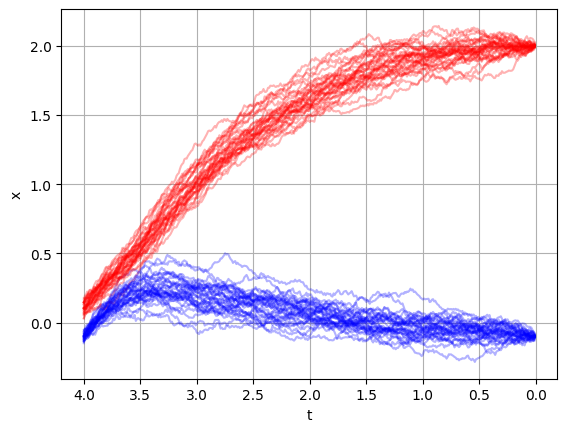

In [158]:
for i in range(32):
    # plt.plot(path.ts, path.xs[i, :, 0], color='r', alpha=0.1)
    # plt.plot(path.ts, path.xs[i, :, 1], color='b', alpha=0.1)
    plt.plot(path.ts, path.xs[i, :, 0], color='r', alpha=0.3)
    plt.plot(path.ts, path.xs[i, :, 1], color='b', alpha=0.3)
plt.xlabel('t')
plt.ylabel('x')
# 获取当前y轴的范围
x_min, x_max = plt.xlim()

# 反转y轴范围，实现沿x轴镜像
plt.xlim(x_max, x_min)
plt.grid()

In [85]:
from mixedbridge.utils.ll_eval import log_likelihood

In [90]:
log_likelihood(reverse_bridge, sm_path, eval_every=1)

Array([2541.3574, 2550.547 , 2534.159 , 2556.3896, 2535.2888, 2561.3882,
       2560.8203, 2534.8665, 2528.095 , 2560.2073, 2528.2385, 2546.2847,
       2543.0466, 2574.9014, 2536.3955, 2539.6233, 2534.381 , 2548.5452,
       2533.1863, 2530.9868, 2535.6353, 2510.5923, 2481.8572, 2555.9023,
       2546.2761, 2522.1084, 2576.4197, 2526.47  , 2509.9658, 2534.9348,
       2503.5886, 2560.0303, 2554.1226, 2545.833 , 2534.9026, 2569.176 ,
       2549.5098, 2539.1504, 2569.1003, 2538.2852, 2547.3945, 2533.3828,
       2535.5823, 2577.893 , 2532.5935, 2513.96  , 2556.8184, 2551.5852,
       2537.0376, 2539.7083, 2604.8423, 2576.3164, 2523.4148, 2546.4226,
       2547.5647, 2540.5012, 2502.2483, 2551.975 , 2532.5234, 2537.304 ,
       2542.705 , 2519.4727, 2499.0713, 2517.801 ], dtype=float32)